In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm
import os
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [4]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_no_interpol_and_location.csv'

In [5]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc.head(60)

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,NaN,NaN,NaN,9.428927012090160,0.496768589146909,NaN,NaN,NaN
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,NaN,NaN,NaN,9.454842449217251,0.490093678290338,NaN,NaN,NaN
12:15:51:63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:67,0.826263400000000,0.764358500000000,9.596221999999999,0.096572876000000,0.284866330000000,-0.356338500000000,NaN,NaN,NaN,9.662009718272166,0.466317781055827,NaN,NaN,NaN
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,NaN,NaN
12:15:51:69,0.651489260000000,0.623107900000000,8.861205999999999,-0.021682740000000,0.496841430000000,-0.363800050000000,NaN,NaN,NaN,8.906945238709721,0.616175319335621,NaN,NaN,NaN


In [6]:
df_sensor_and_loc.loc[:, 'lat'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.loc[:, 'long'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.dropna(inplace=True)
df_sensor_and_loc.shape

(31074, 14)

In [7]:
# Each 20 ms
df_sensor_and_loc.head(10)

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,44.434937499999961,26.047602129736543
12:15:51:70,0.764022800000000,0.639862060000000,8.693603500000000,-0.093048096000000,0.537323000000000,-0.366989140000000,53.250121999999998,-49.650573999999999,-260.699459999999988,8.750536904096773,0.657308894946786,270.675014428439624,44.434937499999954,26.047602287170676
12:15:51:72,0.761627200000000,0.601547240000000,8.547561999999999,-0.231536870000000,0.496841430000000,-0.382980350000000,53.700256000000003,-51.600647000000002,-261.000060000000019,8.602485176829743,0.668681297196179,271.417345770840086,44.434937499999947,26.047602444604813
12:15:51:75,1.024993900000000,0.424377440000000,9.782973999999999,-0.580947900000000,0.266754150000000,-0.371261600000000,54.600524999999998,-48.300170000000001,-260.850520000000017,9.845673617954953,0.739251929108875,270.845191089993193,44.434937499999933,26.047602680756018
12:15:51:76,0.986679100000000,0.407623300000000,10.673614499999999,-0.573486300000000,0.265686040000000,-0.366989140000000,55.050660000000001,-50.250244000000002,-259.649659999999983,10.726869948670483,0.730860203470206,270.136276954078710,44.434937499999926,26.047602759473087
12:15:51:78,0.431228640000000,0.283126830000000,11.054290999999999,-0.396652220000000,0.280593870000000,-0.282836900000000,55.799866000000002,-49.049377000000000,-261.599730000000022,11.066321360529120,0.562194464143961,271.944636214393825,44.434937499999918,26.047602916907220
12:15:51:80,0.558120700000000,0.364532470000000,10.486862000000000,-0.098373410000000,0.309356700000000,-0.109207150000000,55.200195000000001,-48.599243000000001,-260.249329999999986,10.508028228192805,0.342498317136071,270.441604997566856,44.434937499999911,26.047603074341357
12:15:51:83,1.230896000000000,0.994201660000000,8.537979000000000,0.072067260000000,0.193252560000000,0.019699097000000,55.200195000000001,-48.599243000000001,-260.249329999999986,8.683353459810544,0.207191448503737,270.441604997566856,44.434937499999897,26.047603310492562
12:15:51:85,1.467910800000000,1.331787100000000,8.006470000000000,-0.067489624000000,-0.018737793000000,-0.014389038000000,56.550600000000003,-47.999572999999998,-262.350459999999998,8.248150147601766,0.071505235114204,272.634724917340520,44.434937499999890,26.047603467926695


## 1.1. Creating x and y

In [8]:
# df_sensor_and_loc['x'] = np.nan
# df_sensor_and_loc['y'] = np.nan
# for i in range(len(df_sensor_and_loc)):
#     lat = df_sensor_and_loc['lat'].iloc[i]
#     long = df_sensor_and_loc['long'].iloc[i]
#     df_sensor_and_loc['x'].iloc[i], df_sensor_and_loc['y'].iloc[i], zone, ut = utm.from_latlon(df_sensor_and_loc['lat'].iloc[i], df_sensor_and_loc['long'].iloc[i])
# df_sensor_and_loc

In [9]:
# plt.scatter(x=df_sensor_and_loc['x'], y=df_sensor_and_loc['y'])

In [10]:
# ::5 - each 100ms, ::10 -- each 200 ms
downsample_interval=5
data = df_sensor_and_loc.copy(deep=True)[::downsample_interval]
# data = data.iloc[:(len(data)//3), :]
print(data.shape)
print(data.head(10))

(6215, 14)
                           ax                 ay                 az  \
12:15:51:60 0.558120700000000  0.496215820000000  9.361587999999999   
12:15:51:76 0.986679100000000  0.407623300000000 10.673614499999999   
12:15:51:87 1.343414300000000  1.456283600000000  8.241104000000000   
12:15:51:96 1.092025800000000  1.726821900000000  9.117386000000000   
12:15:52:07 1.060897800000000  1.839355500000000 10.173218000000000   
12:15:52:17 1.039352400000000  1.180954000000000 10.731064000000000   
12:15:52:27 0.146316530000000 -0.353729250000000 11.063858000000000   
12:15:52:37 1.063293500000000  0.426773070000000 10.632904000000000   
12:15:52:47 0.246871950000000  0.060470580000000  8.296173000000000   
12:15:52:57 0.622756960000000  0.295089720000000  9.160477000000000   

                            gx                 gy                 gz  \
12:15:51:60  0.074188230000000  0.290191650000000 -0.387237550000000   
12:15:51:76 -0.573486300000000  0.265686040000000 -0.3669891400

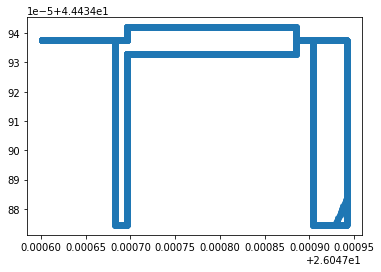

In [11]:
plt.scatter(data['long'], data['lat'])

In [12]:
# plt.plot(data['x'], data['y'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [13]:
backcandles=100

sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(data.iloc[:, :-2])

sc_targets = MinMaxScaler(feature_range=(0, 1))
targets_scaled = sc_targets.fit_transform(data.iloc[backcandles:, [-2, -1]])
# y_test_1 = data.iloc[:, [-2, -1]]
# print(y_test_1)
# y_test_sc = sc.fit_transform(data.iloc[:, [-2, -1]])
# print(data_scaled)

In [14]:
print(attributes_scaled.shape[0], attributes_scaled.shape[1], targets_scaled.shape)

6215 12 (6115, 2)


## 2.2. Principal Component Analysis (PCA)

In [15]:
# Apply PCA with 90% desired components
pca = PCA(0.99)
X_pca = pca.fit_transform(attributes_scaled)
X_pca.shape

(6215, 10)

In [16]:
# pca.fit_transform(attributes_scaled)

## 2.2. Reshaping the data in order to feed it to the model

In [17]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [18]:
X = []
backcandles=backcandles # number of last values to look into

for i in range(X_pca.shape[1]): #number of attributes columns
    X.append([])
    for j in range(backcandles, attributes_scaled.shape[0]):
        X[i].append(attributes_scaled[j-backcandles:j, i])

print(np.array(X).shape)

# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X.shape

(10, 6115, 100)


(6115, 100, 10)

In [19]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, y = np.array(X), np.array(targets_scaled)

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
targets_scaled

X Shape:  (6115, 100, 10)
y shape:  (6115, 2)


array([[0.86857167, 0.24055327],
       [0.86222246, 0.24055327],
       [0.85587326, 0.24055327],
       ...,
       [0.93333312, 0.00839689],
       [0.93333312, 0.00530971],
       [0.93333312, 0.00222253]])

## 2.3. Split the data into train, test and validation sets

In [20]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

4280 5503
(4280, 100, 10)
(1223, 100, 10)
(612, 100, 10)
(4280, 2)
(1223, 2)
(612, 2)


## 2.4. Creating the LSTM  model

### 2.4.1. Create function to plot the training

In [21]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

### 2.4.2. Saving the model checkpoint

In [22]:
# checkpoint_path = "checkpoints/pca_100ep_100bs_100bc/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

### 2.4.2. Parametrizing the model

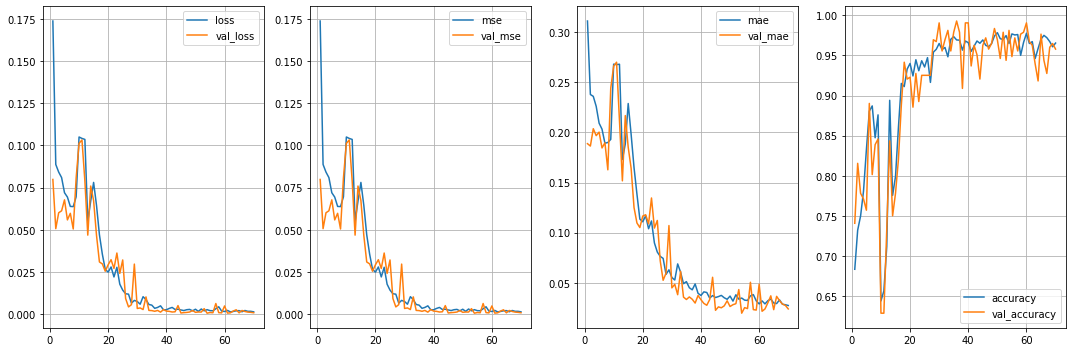


Epoch 70: saving model to checkpoints/pca_70ep_100bs_100bc_5freq\cp.ckpt
39/39 [==============================] - 11s 292ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0274 - accuracy: 0.9655 - val_loss: 9.2374e-04 - val_mse: 9.2374e-04 - val_mae: 0.0239 - val_accuracy: 0.9579
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\dense
......vars
.........0
.........1
...layers\input_layer
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\mean_metric_wrapper_1
......vars
.........0
.........1
...metrics\mean_metric_wrapper_2
......vars
.........0
.........1
...vars
Keras model archive saving:
File Name                                             Modified             Si

In [23]:
attributes_cols = X_pca.shape[1]
batch_size=100
epochs=70
# checkpoint_path = f"checkpoints/test/cp.ckpt"
checkpoint_path = f"checkpoints/pca_{epochs}ep_{batch_size}bs_{backcandles}bc_{downsample_interval}freq/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
# TODO: don't use relu here, it went bad
inputs = LSTM(128, name='first_layer', return_sequences=True)(lstm_input)
# inputs = Dropout(0.2)(inputs)
inputs = LSTM(64, name='second_layer', return_sequences=False)(inputs)
# inputs = Dropout(0.2)(inputs)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(optimizer=RMSprop(learning_rate=0.005), loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False, 
          validation_split=0.1,
          callbacks=[PlotLearning(), cp_callback])

# save the model to disk
filename = 'finalized_model.sav'
filename = f"models/pca_{epochs}ep_{batch_size}bs_{backcandles}bc_{downsample_interval}freq.sav"
pickle.dump(model, open(filename, 'wb'))

# model = Sequential()
# model.add(LSTM(128, activation='relu', name='first_layer', return_sequences=True))
# model.add(LSTM(128, activation='relu', name='second_layer', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(2, name='dense_layer'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=epochs)

In [24]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
len(y_pred), len(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

39/39 [==============================] - 2s 33ms/step
[0.9158907  0.25804603] [0.93333317 0.19304129]
[0.91589236 0.2591149 ] [0.93333317 0.19211513]
[0.9180753  0.25901675] [0.93333317 0.19091113]
[0.9231143  0.25506747] [0.93333317 0.18998497]
[0.92727315 0.24772541] [0.93333317 0.18915144]
[0.9273702  0.25036156] [0.93333317 0.18822528]
[0.92856944 0.25321552] [0.93333317 0.18729913]
[0.9270042 0.2557028] [0.93333317 0.18637297]
[0.927138 0.251633] [0.93333317 0.1853542 ]
[0.9273211 0.2477949] [0.93333317 0.18292562]
Mean Squared Error (MSE): 0.0029702905988859512
R-squared: 0.9671586062688418


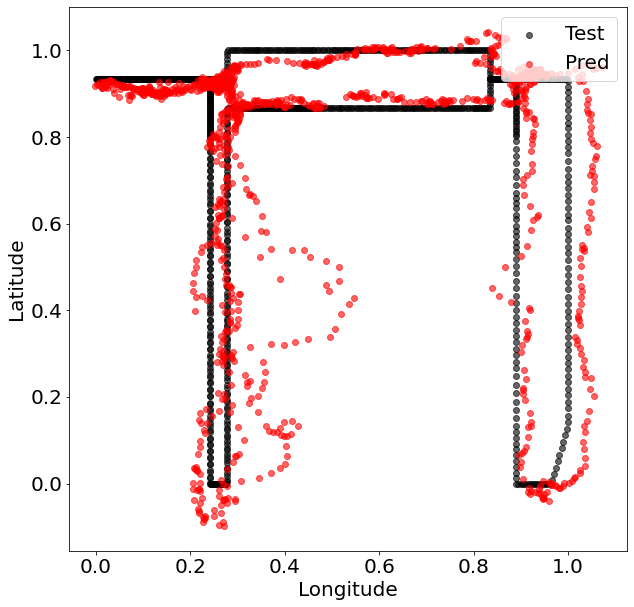

In [25]:
# import matplotlib
font = {'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,10))

plt.scatter(x=y_test[:, 1], 
            y=y_test[:, 0], 
            alpha=0.6, 
            color='black', 
            label='Test')
plt.scatter(x=y_pred[:, 1], 
            y=y_pred[:, 0], 
            alpha=0.6, 
            color='red', 
            label='Pred')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='upper right')

In [26]:
import time

font = {'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,10))

    
import ipywidgets as widgets

def plot_with_steps(row):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper right')
    plt.ylim(-0.2, 1.2)
    plt.xlim(-0.2, 1.2)
    plt.scatter(x=y_test[:row, 1], 
               y=y_test[:row, 0], 
               alpha=0.6, 
               color='black', 
               label='Test')
    plt.scatter(x=y_pred[:row, 1], 
               y=y_pred[:row, 0], 
               alpha=0.4, 
               color='red', 
               label='Pred')

for i in range(0,len(y_test)-20, 20):
    button = widgets.interact(plot_with_steps, row=i)
    output = widgets.Output()

    display(button, output)
    time.sleep(0.1)
    clear_output(wait=True)


interactive(children=(IntSlider(value=1200, description='row', max=3600, min=-1200), Output()), _dom_classes=(…

<function __main__.plot_with_steps(row)>

Output()

Mean Squared Error (MSE): 1.8307551886103573e-10
R-squared: 0.9611441866013954
[[44.4349375  26.04766721]
 [44.4349375  26.0476669 ]
 [44.4349375  26.04766649]
 ...
 [44.434933   26.04775736]
 [44.434933   26.04775909]
 [44.434933   26.04776098]] [[44.434937 26.047691]
 [44.434937 26.047691]
 [44.434937 26.047691]
 ...
 [44.434937 26.047739]
 [44.434937 26.047739]
 [44.434937 26.04774 ]]


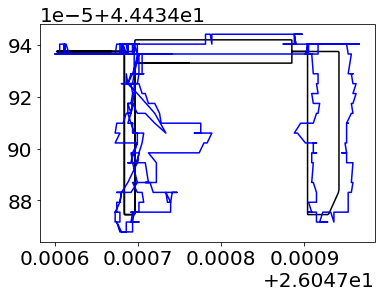

In [27]:
y_test_normalized = sc_targets.inverse_transform(y_test)
y_pred_normalized = sc_targets.inverse_transform(y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_normalized, y_pred_normalized)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test_normalized, y_pred_normalized)
print("R-squared:", r2)

plt.plot(y_test_normalized[:, 1], y_test_normalized[:, 0], color='black', label='Test')
plt.plot(y_pred_normalized[:, 1], y_pred_normalized[:, 0], color='blue', label='Pred')
print(y_test_normalized, y_pred_normalized)

In [28]:
model.evaluate(X_test, y_test)

39/39 [==============================] - 1s 31ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0389 - accuracy: 0.9640


[0.002970290370285511,
 0.002970290370285511,
 0.03890012577176094,
 0.9640228748321533]

In [29]:
from math import radians, cos, sin, asin, acos, sqrt, pi
import geopy.distance

def calculate_spherical_distance(row):
    " Calculates the distance in km with the haversine method, which assumes the earth is sphere"
    lat1 = row['lat1']
    lon1 = row['long1']
    lat2 = row['lat2']
    lon2 = row['long2']
    r=6371
    # Convert degrees to radians
    coordinates = lat1, lon1, lat2, lon2
    phi1, lambda1, phi2, lambda2 = [
        radians(c) for c in coordinates
    ]
    
    # Apply the haversine formula
    d = r*acos(cos(phi2-phi1) - cos(phi1) * cos(phi2) *
              (1-cos(lambda2-lambda1)))
    return d

def calculate_vincenty_distance(row):
    coords_1 = (row['lat1'], row['long1'])
    coords_2 = (row['lat2'], row['long2'])
    
    return geopy.distance.geodesic(coords_1, coords_2).km

In [30]:
y_pred_step_2 = pd.DataFrame(y_pred_normalized, columns=['lat1', 'long1'])
y_test_step_2 = pd.DataFrame(y_test_normalized, columns=['lat2', 'long2'])

# alculating the Euclidian distance between points
distance_df = pd.DataFrame((y_test_step_2['lat2']-y_pred_step_2['lat1'])**2 + 
                           (y_test_step_2['long2']-y_pred_step_2['long1'])**2)**(1/2)
sum_dist = distance_df.sum()
mean_error = sum_dist/len(distance_df)
mean_error

0   0.000015193640900
dtype: float64

## Calculating MSE, RMSE and STD

In [31]:
df_final = pd.DataFrame()
df_final = pd.concat([y_pred_step_2, y_test_step_2], axis=1)

df_final['km_difference_haversine'] = df_final.apply(calculate_spherical_distance, axis=1)
df_final['m_difference_haversine'] = df_final['km_difference_haversine']*1000

df_final['km_difference_vincenty'] = df_final.apply(calculate_vincenty_distance, axis=1)
df_final['m_difference_vincenty'] = df_final['km_difference_vincenty']*1000

# Transform all the differences in positive values for Standard Deviation
df_final['m_difference_haversine_module']=np.sqrt(df_final['m_difference_haversine']*df_final['m_difference_haversine'])
df_final['m_difference_vincenty_module']=np.sqrt(df_final['m_difference_vincenty']*df_final['m_difference_vincenty'])

# Mean Squared Error Haversine
mse_h = (df_final['m_difference_haversine']*df_final['m_difference_haversine']).sum()/len(df_final)
print(f'Mean Squared Error for Haversine is: {mse_h} m^2')
# Root Mean Squared Error Haversine
rmse_h = np.sqrt(mse_h)
print(f'Root Mean Squared error for Haversine is: {rmse_h} m')
# Mean Absoulte Deviation (MAD)
mad_h = df_final['m_difference_haversine_module'].sum()/len(df_final)
print(f'Mean Absoulte Deviation for Haversine is: {mad_h} m')
# Standard Deviation for Haversine
haversine_std = df_final['m_difference_vincenty_module'].std()
print(f'Standard Deviation Error for Haversine is: {haversine_std} m')
print('')

# Mean Squared Error Vincenty
mse_v = (df_final['m_difference_vincenty']*df_final['m_difference_vincenty']).sum()/len(df_final)
print(f'Mean Squared Error for Vincenty is: {mse_v} m^2')
# Root Mean Squared Error Haversine
rmse_v = np.sqrt(mse_v)
print(f'Root Mean Squared Error for Vincenty is: {rmse_v} m')
# Mean Absoulte Deviation (MAD)
mad_v = df_final['m_difference_vincenty_module'].sum()/len(df_final)
print(f'Mean Absoulte Deviation for Vincenty is: {mad_v} m')
# Standard Deviation for Vincenty
varcity_std = df_final['m_difference_vincenty_module'].std()
print(f'Standard Deviation Error for Vincenty is: {varcity_std} m')

df_final.loc[:, ['m_difference_vincenty', 'm_difference_haversine']]

Mean Squared Error for Haversine is: 2.416725607399574 m^2
Root Mean Squared error for Haversine is: 1.5545821327287839 m
Mean Absoulte Deviation for Haversine is: 1.2595720565112611 m
Standard Deviation Error for Haversine is: 0.9139080386213926 m

Mean Squared Error for Vincenty is: 2.429392856967801 m^2
Root Mean Squared Error for Vincenty is: 1.5586509734279195 m
Mean Absoulte Deviation for Vincenty is: 1.2628728707202292 m
Standard Deviation Error for Vincenty is: 0.9139080386213926 m


,m_difference_vincenty,m_difference_haversine
0,1.924425376305271,1.917599021265061
1,1.949455171005802,1.943277083988681
2,1.981995392039479,1.975475582322917
3,1.703832400641482,1.698254237729454
4,1.574819469806417,1.568588552926176
...,...,...
1218,1.562251192625019,1.557054657091863
1219,1.683897065091495,1.679576875396536
1220,1.510971769312150,1.507051134359170
1221,1.644539404506778,1.638837337373171


In [32]:
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

Text(0.5, 0, 'Difference (m)')

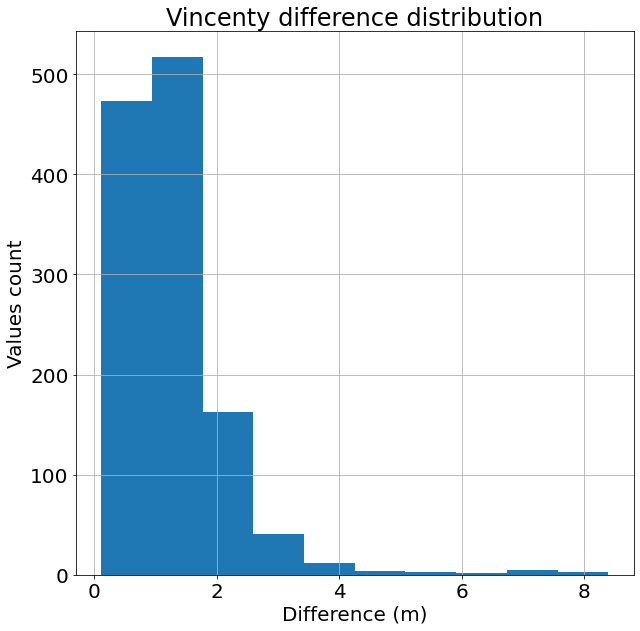

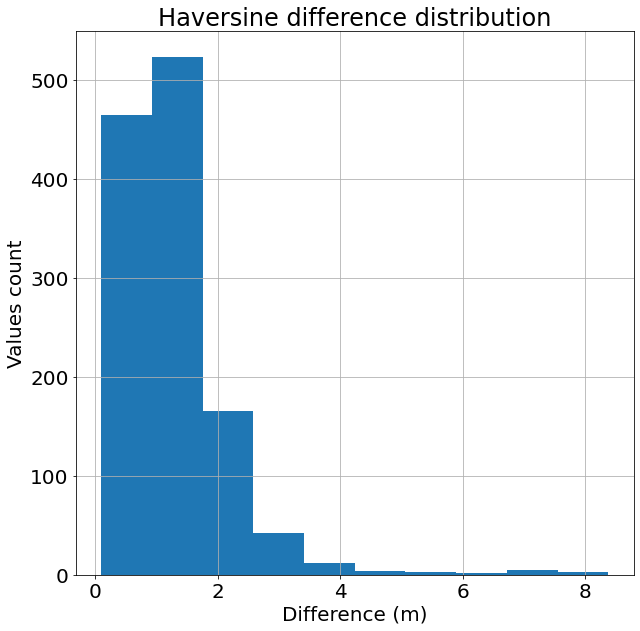

In [33]:
# Data distribution / histograms
font = {'size': 20}
matplotlib.rc('font', **font)

df_final['Vincenty difference distribution'] = df_final['m_difference_vincenty']
df_final.hist(column=['Vincenty difference distribution'], figsize=(10, 10))
plt.ylabel('Values count')
plt.xlabel('Difference (m)')

df_final['Haversine difference distribution'] = df_final['m_difference_haversine']
df_final.hist(column=['Haversine difference distribution'], figsize=(10, 10))
plt.ylabel('Values count')
plt.xlabel('Difference (m)')

In [34]:
# Transform all the differences in positive values 
df_final['m_difference_haversine_module']=np.sqrt(df_final['m_difference_haversine']*df_final['m_difference_haversine'])
df_final['m_difference_vincenty_module']=np.sqrt(df_final['m_difference_vincenty']*df_final['m_difference_vincenty'])
df_final

,lat1,long1,lat2,long2,km_difference_haversine,m_difference_haversine,km_difference_vincenty,m_difference_vincenty,m_difference_haversine_module,m_difference_vincenty_module,Vincenty difference distribution,Haversine difference distribution
0,44.434936523437500,26.047691345214844,44.434937499968171,26.047667212924928,0.001917599021265,1.917599021265061,0.001924425376305,1.924425376305271,1.917599021265061,1.924425376305271,1.924425376305271,1.917599021265061
1,44.434936523437500,26.047691345214844,44.434937499968157,26.047666898056658,0.001943277083989,1.943277083988681,0.001949455171006,1.949455171005802,1.943277083988681,1.949455171005802,1.949455171005802,1.943277083988681
2,44.434936523437500,26.047691345214844,44.434937499968136,26.047666488727906,0.001975475582323,1.975475582322917,0.001981995392039,1.981995392039479,1.975475582322917,1.981995392039479,1.981995392039479,1.975475582322917
3,44.434936523437500,26.047687530517578,44.434937499968115,26.047666173859636,0.001698254237729,1.698254237729454,0.001703832400641,1.703832400641482,1.698254237729454,1.703832400641482,1.703832400641482,1.698254237729454
4,44.434936523437500,26.047685623168945,44.434937499968100,26.047665890478189,0.001568588552926,1.568588552926176,0.001574819469806,1.574819469806417,1.568588552926176,1.574819469806417,1.574819469806417,1.568588552926176
...,...,...,...,...,...,...,...,...,...,...,...,...
1218,44.434936523437500,26.047735214233398,44.434933003383740,26.047754211093647,0.001557054657092,1.557054657091863,0.001562251192625,1.562251192625019,1.557054657091863,1.562251192625019,1.562251192625019,1.557054657091863
1219,44.434936523437500,26.047735214233398,44.434933003383648,26.047755785434880,0.001679576875397,1.679576875396536,0.001683897065091,1.683897065091495,1.679576875396536,1.683897065091495,1.683897065091495,1.679576875396536
1220,44.434936523437500,26.047739028930664,44.434933003383563,26.047757359776121,0.001507051134359,1.507051134359170,0.001510971769312,1.510971769312150,1.507051134359170,1.510971769312150,1.510971769312150,1.507051134359170
1221,44.434936523437500,26.047739028930664,44.434933003383470,26.047759091551480,0.001638837337373,1.638837337373171,0.001644539404507,1.644539404506778,1.638837337373171,1.644539404506778,1.644539404506778,1.638837337373171


In [35]:
haversine_mean = df_final.loc[:, ['m_difference_haversine']].mean()
vincenty_mean = df_final.loc[:, ['m_difference_vincenty']].mean()
haversine_mean, vincenty_mean

(m_difference_haversine   1.259572056511261
 dtype: float64,
 m_difference_vincenty   1.262872870720229
 dtype: float64)

In [36]:
haversine_std = df_final['m_difference_vincenty_module'].std()
varcity_std = df_final['m_difference_haversine_module'].std()
haversine_std, varcity_std

(0.9139080386213926, 0.911527960661775)